# Neural Networks

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Normalization
from sklearn import preprocessing

sns.set_style("whitegrid")

The data has been divided into 3 sets: train, validation and test.

In [2]:
data_train = pd.read_excel("./data/pumpFeaturesNets.xlsx", sheet_name="dataTrain")
data_train.faultCode = pd.Categorical(data_train.faultCode)
data_test = pd.read_excel("./data/pumpFeaturesNets.xlsx", sheet_name="dataTest")
data_test.faultCode = pd.Categorical(data_test.faultCode)
data_val = pd.read_excel("./data/pumpFeaturesNets.xlsx", sheet_name="dataVal")
data_val.faultCode = pd.Categorical(data_val.faultCode)

Let's first encode the values of the y_train, y_test and y_val variables using the [LabelEncoder()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html#sklearn-preprocessing-labelencoder) class.

Then let's encode the labels using the [one_hot()](https://www.tensorflow.org/api_docs/python/tf/one_hot) function.

In [3]:
X_train, y_train,  = data_train.iloc[:, :-1], data_train.iloc[:, -1]
X_test, y_test = data_test.iloc[:, :-1], data_test.iloc[:, -1]
X_val, y_val = data_val.iloc[:, :-1], data_val.iloc[:, -1]

encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)
y_val = encoder.transform(y_val)

y_train_one_hot = tf.one_hot(y_train, y_train.max()+1)
y_test_one_hot = tf.one_hot(y_test, y_test.max()+1)
y_val_one_hot = tf.one_hot(y_val, y_val.max()+1)

This function is used to evaluate a model by displaying the confusion chart and accuracy.

In [4]:
def eval_model(X_test, y_test, model):
    print("Accuracy:", model.evaluate(X_test, y_test, verbose=False)[1])
    cm = confusion_matrix(tf.math.argmax(y_test_one_hot, axis=1), tf.math.argmax(model.predict(X_test, verbose=False), axis=1))

    plt.figure()
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data_train.faultCode.cat.categories).plot();
    plt.grid(visible=False)
    plt.show()

Neural networks require data to be standardized, otherwise they fail to converge to a solution. To address this, we can use the [Normalization()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization) class. To create a sequential model we use the [Sequential()](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) class. We can add neural network layers to the sequential model using the add() function. First we use the [Input()](https://www.tensorflow.org/api_docs/python/tf/keras/Input) function to set the shape of the input data and then we add two fully connected layers using the [Dense()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) class.

In [5]:
normalization_layer = Normalization(axis=1)
normalization_layer.adapt(X_train)

model = keras.Sequential()
model.add(keras.Input(shape=(X_train.shape[1],)))
model.add(normalization_layer)
model.add(Dense(48, activation="relu"))
model.add(Dense(y_train_one_hot.shape[1], activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 84)               169       
 n)                                                              
                                                                 
 dense (Dense)               (None, 48)                4080      
                                                                 
 dense_1 (Dense)             (None, 8)                 392       
                                                                 
Total params: 4,641
Trainable params: 4,472
Non-trainable params: 169
_________________________________________________________________


Configures the model for training.

In [6]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

To prevent overfitting a neural network, it is a good practice to use a validation set to stop training once the validation loss stops improving. We can use the "validation_data" property to specify the data used for validation. Setting the "callbacks" property to monitor the validation loss tells the network to stop training if the validation loss has not improved after a certain number of iterations.

In [7]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
history = model.fit(X_train, y_train_one_hot, epochs=100, validation_data=(X_val, y_val_one_hot), callbacks=[callback])

Epoch 1/100
22/22 [==============================] - 1s 15ms/step - loss: 1.9264 - accuracy: 0.2386 - val_loss: 1.4765 - val_accuracy: 0.4133
Epoch 2/100
22/22 [==============================] - 0s 3ms/step - loss: 1.2623 - accuracy: 0.5457 - val_loss: 1.1953 - val_accuracy: 0.5467
Epoch 3/100
22/22 [==============================] - 0s 3ms/step - loss: 1.0269 - accuracy: 0.6386 - val_loss: 1.0629 - val_accuracy: 0.6000
Epoch 4/100
22/22 [==============================] - 0s 3ms/step - loss: 0.9027 - accuracy: 0.6814 - val_loss: 0.9720 - val_accuracy: 0.6200
Epoch 5/100
22/22 [==============================] - 0s 3ms/step - loss: 0.8165 - accuracy: 0.6986 - val_loss: 0.9013 - val_accuracy: 0.6533
Epoch 6/100
22/22 [==============================] - 0s 3ms/step - loss: 0.7554 - accuracy: 0.7071 - val_loss: 0.8530 - val_accuracy: 0.6733
Epoch 7/100
22/22 [==============================] - 0s 3ms/step - loss: 0.7048 - accuracy: 0.7257 - val_loss: 0.8108 - val_accuracy: 0.6933
Epoch 8/100


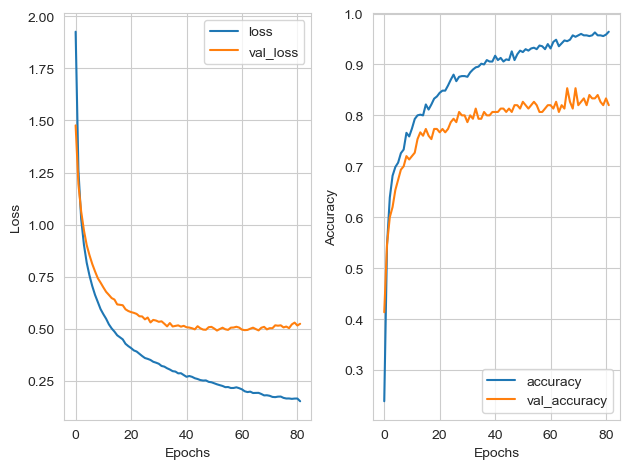

In [8]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(range(len(history.history['loss'])), history.history['loss'])
axs[0].plot(range(len(history.history['val_loss'])), history.history['val_loss'])
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['loss', 'val_loss'])

axs[1].plot(range(len(history.history['accuracy'])), history.history['accuracy'])
axs[1].plot(range(len(history.history['val_accuracy'])), history.history['val_accuracy'])
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['accuracy', 'val_accuracy'])

plt.tight_layout()
plt.show()

Evaluate model.

Accuracy: 0.7933333516120911


<Figure size 640x480 with 0 Axes>

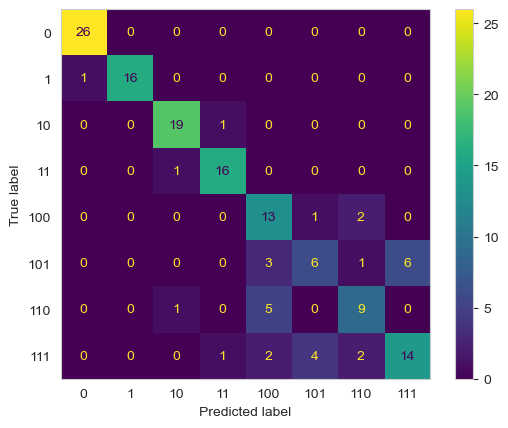

In [9]:
eval_model(X_test, y_test_one_hot, model)